# Neural Network

In this assignment you will build an artificial neural network _from scratch_, meaning without modern machine learning packages (e.g. scikit-learn, tensorflow, and pytorch). You should use numpy, and can use other standard python libraries if you like. 

## Part 1: Neural Network with Stochastic Gradient Descent (4 points)
Define a class NeuralNetwork that implements an artificial neural network with a single hidden layer. The hidden layer should use the Rectified Linear Unit (ReLU) non-linear activation function, and the output should have a Softmax activation function. Use the template provided. 

This first part should implement SGD with a mini-batch size of 1. This is a simplified case of Part 3, which asks you to implement mini-batch gradient descent with a mini-batch size greater than 1. You should start with Part 1 because it is simpler. However, it is fine to turn in just the solution in Part 3 because that is the more general case.

The hard part of this is the **train** method, which requires computing lots of gradients. See the [notes on neural networks](https://laulima.hawaii.edu/access/content/group/MAN.XLSIDIN35ps.202230/Notes_6__Introduction_to_Neural_Networks.pdf) on Laulima to see the equations for calculating these analytically. Translating these equations into code is non-trivial. The **backpropagation** algorithm is a dynamic programming algorithm that computes the gradients layer by layer, and can be written very elegantly in terms of matrix manipulations (a couple lines of numpy code).

_Reminder: Do NOT copy and paste code from the internet. All code should be written by you._

## Part 2: Apply Your Model to Fashion Dataset (3 points)
We will test the model on the Fashion MNIST dataset. This is a 10-class classification task designed to be similar to the MNIST digit recognition dataset. The classes are different items of clothing (shoes, shirts, handbags, etc.) instead of digits. Here is an [introduction](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) and [github page](https://github.com/zalandoresearch/fashion-mnist).

1. Demonstrate overfitting in your network by plotting the training and test set losses vs. epoch. An *epoch* is one iteration through the training set; in SGD this means one weight update for each training example. You can use a smaller dataset so that you overfit faster, but clearly state how many examples are in your train and test sets.
2. Optimize the hyperparameters of the neural network. You can try different numbers of neurons and the learning rate. Because the test dataset is fairly large (10k examples), you don't need to split off a separate validation set for this analysis. Report the best performance (validation accuracy) and the best hyperparameters. 
3. Visualize the 10 test examples with the largest loss.

## Part 3: Better and Faster: Mini-Batch SGD (3 points)
Implement mini-batch gradient descent in your NeuralNetwork train method. This is much more efficient to update the weights on *batches* of training data, e.g. 100 examples at a time, which serves two purposes: 
1. Each update is a better, less-noisy estimate of the true gradient
2. The matrix multiplications can be parallelized for an almost-linear speedup with multiple cores or a GPU. By default, numpy should automatically use multiple CPUs for matrix multiplications. This requires implementing the forward and backpropagation computations efficiently, using matrix multiplications rather than for loops. 


In [1]:
# Part 1: Defining the neural network.
class NeuralNetwork():
    
    def __init__(self, inputs, hidden, outputs):
        """
        Initialize a simple neural network with a single hidden layer.
        This method randomly initializes the parameters of the model,
        saving them as private variables.
        
        Each layer is parameterized by a weight matrix and a bias vector; 
        a useful trick is store the weights and biases for a layer together,
        as a single matrix.
        
        Args:
            inputs: int, input dimension
            hidden: int, number of hidden neurons
            outputs: int, number of output neurons
        Returns:
            None
        """
        
        # Initialize the weights and biases of the neural network as
        # private variables. Store a weight matrix for each layer. 
        
        # np.random.seed(1)

        # initialize parameters randomly with mean 0
        # the weights and biases connecting the input and hidden layer
        # self.W1 = 2 * np.random.rand(inputs + 1, hidden) - 1
        self.W1 = 0.2 * np.random.rand(inputs + 1, hidden) - 0.1 # try [-0.1, 0.1)

        # the weights and biases connecting the hidden and output layer
        # self.W2 = 2 * np.random.rand(hidden + 1, outputs) - 1
        self.W2 = 0.2 * np.random.rand(hidden + 1, outputs) - 0.1 # try [-0.1, 0.1)
        
    def softmax(self, z):
        """
        Compute softmax function.

        Args:
            z: the pre activation
        Returns:
            y: the activation
        """

        # exp-normalize trick
        max = np.max(z, axis=1).reshape(-1, 1) # find max(z) per row
        e = np.exp(z - max) # compute e^(z_i - max(z)) for each element
        s = np.sum(e, axis=1).reshape(-1, 1) # sum across rows
        
        return e / s

    def loss(self, y_true, y_pred):
        """
        Compute categorical cross-entropy loss function. 
        
        Sum loss contributions over the outputs (axis=1), but 
        average over the examples (axis=0)
        
        Args: 
            y_true: NxD numpy array with N examples, D outputs (one-hot labels).
            y_pred: NxD numpy array with N examples, D outputs (probabilities).
        Returns:
            loss: array of length N representing loss for each example.
        """

        # get the probability of the positive class for each sample (row)
        P = np.sum(( y_true * y_pred ), axis=1)

        # return the cross-entropy loss for each sample (row)
        return -np.log(P)
        
    def evaluate(self, X, y):
        """
        Make predictions and compute loss.
        Args:
            X: NxM numpy array where n-th row is an input.
            y: NxD numpy array with N examples and D outputs (one-hot labels).
        Returns:
            loss: array of length N representing loss for each example.
        """
        
        # make predictions
        y_pred = self.predict(X)
        # compute loss
        return self.loss(y, y_pred)
        
    def predict(self, X):
        """
        Make predictions on inputs X.
        Args:
            X: NxM numpy array where n-th row is an input.
        Returns: 
            y_pred: NxD array where n-th row is vector of probabilities.
        """
        
        # forward propagation

        # append ones to each row in input X to represent the biases
        X_bias = np.ones((X.shape[0], 1), dtype=int)
        X_with_bias = np.concatenate(( X, X_bias ), axis=1)

        # compute the hidden activation (ReLU)
        preact_H = np.dot(X_with_bias, self.W1)
        H = np.clip(preact_H, a_min=0, a_max=None)

        # append ones to each row in H to represent the biases
        H_bias = np.ones((H.shape[0], 1), dtype=int)
        H_with_bias = np.concatenate(( H, H_bias ), axis=1)

        # compute the output (Softmax)
        preact_y_pred = np.dot(H_with_bias, self.W2)
        y_pred = self.softmax(preact_y_pred)

        return y_pred
        
    def train(self, X, y, batch_size=100, lr=0.0001, max_epochs=10, x_val=None, y_val=None, verbose=False):
        """
        Train the neural network using stochastic gradient descent.
        
        Args:
            X: NxM numpy array where n-th row is an input.
            y: NxD numpy array with N examples and D outputs (one-hot labels).
            lr: scalar learning rate. Use small value for debugging.
            max_epochs: int, each epoch is one iteration through the train data.
            x_val: numpy array containing validation data inputs.
            y_val: numpy array containing validation data outputs.
        Returns:
            history: dict with the following key, value pairs:
                     'loss' -> list containing the training loss at each epoch
                     'loss_val' -> list for the validation loss at each epoch
        """

        history = {
            'loss': [],
            'loss_val': []
        }

        indices = np.arange(X.shape[0])

        for i in range(max_epochs):

            np.random.shuffle(indices) # the shuffled indices
            sum_loss = []

            # iterate over the train data w/ step size = batch size
            for j in range(0, X.shape[0], batch_size):

                # prepare the mini batches

                indicies_mini = indices[j:j + batch_size]
                X_mini = X[indicies_mini]
                y_mini = y[indicies_mini]

                # forward propagation (just mini batch)

                # append ones to each row in input X to represent the biases
                X_bias = np.ones((X_mini.shape[0], 1), dtype=int)
                X_with_bias = np.concatenate(( X_mini, X_bias ), axis=1)

                # compute the hidden activation (ReLU)
                preact_H = np.dot(X_with_bias, self.W1)
                H = np.clip(preact_H, a_min=0, a_max=None)

                # append ones to each row in H to represent the biases
                H_bias = np.ones((H.shape[0], 1), dtype=int)
                H_with_bias = np.concatenate(( H, H_bias ), axis=1)

                # compute the output (Softmax)
                preact_y_pred = np.dot(H_with_bias, self.W2)
                y_pred = self.softmax(preact_y_pred)

                # sum the train loss
                sum_loss.append( self.loss(y_mini, y_pred) )

                # backpropagation (just mini batch)

                # compute the gradient of the loss w/ respect to the pre activation of y (output)
                # important simplification!
                y_delta = y_pred - y_mini # dL/dz
                
                # compute the gradient of the loss w/ respect to the pre activation of H (hidden)
                # dz/dH = self.W2[:-1] (bias = 0)
                # ReLU gradient:
                # 0 if preact_H <= 0
                # 1 if preact_H > 0
                ReLU_delta = np.heaviside(preact_H, 0) # dH/dz_hidden

                H_delta = np.dot(y_delta, self.W2[:-1].T) * ReLU_delta

                # update the weights and biases (Mini-Batch Trick)
                self.W2 -= lr * np.dot(H_with_bias.T, y_delta) # step size is lr * dL/dW2
                self.W1 -= lr * np.dot(X_with_bias.T, H_delta) # step size is lr * dL/dW1

            # update history

            # compute the mean cross entropy loss and append to list (entire dataset)
            # train_loss = np.mean( self.evaluate(X, y) )
            train_loss = np.mean( sum_loss )
            history['loss'].append(train_loss)

            if x_val is not None:
                val_loss = np.mean( self.evaluate(x_val, y_val) )
                history['loss_val'].append(val_loss)

            if (verbose):
                # print(f'indices: {indices}')
                print(f'train loss: {train_loss}')
                print(f'val loss: {val_loss}')

        return history
        

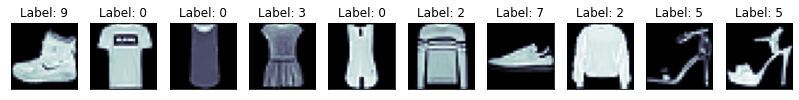

In [2]:
# Download Fashion MNIST Dataset
import gzip
import os
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt

def fashion_mnist():
    """
    Download compressed Fashion MNIST data to local directory, and 
    unpack data into numpy arrays. 
    
    Return (train_images, train_labels, test_images, test_labels).

    Args:
        None

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']
    path = './' # Download data to current directory.
    os.makedirs(path, exist_ok=True) # Create path if it doesn't exist.

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))
    
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = fashion_mnist()

# Plot examples from dataset.
plt.figure(1, figsize=(14,6))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(train_images[i,:].reshape(28,28), cmap='bone')
    plt.title(f'Label: {train_labels[i].argmax()}')
    plt.xticks([])
    plt.yticks([])

In [3]:
# Part 2: Applying the model to the dataset

# split train to train and val
X_train, X_val = np.array( np.split(train_images, [42000, ]), dtype=object )
y_train, y_val = np.array( np.split(train_labels, [42000, ]), dtype=object )

In [4]:
hidden = 500 # the number of hidden neurons
sgd = NeuralNetwork(X_train.shape[1], hidden, y_train.shape[1])
history = sgd.train(X=X_train[:100], y=y_train[:100], batch_size=1, lr=0.005, max_epochs=500, x_val=X_val[:100], y_val=y_val[:100], verbose=False)

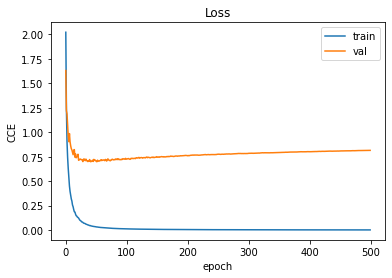

In [5]:
x = np.arange(500, dtype=int) # the epochs
plt.plot(x, history['loss'], label='train')
plt.plot(x, history['loss_val'], label='val')
plt.xlabel('epoch')
plt.ylabel('CCE')
plt.title('Loss')
plt.legend()

The above plot demonstrates overfitting with a train set of 100 samples and a validation set of 100 samples. It can be seen that the gap between the train loss and the validation loss is increasing. The model performs increasingly well on the train set but increasingly worse on the validation set; the model has poor generalization. 

In [ ]:
def accuracy(y_true, y_pred):
    y_true_idx = np.argmax(y_true, axis=1) # get the index of the max per row
    y_pred_idx = np.argmax(y_pred, axis=1)

    # sum the number of matching indices (the true positives), then divide by the total
    return np.sum((y_true_idx == y_pred_idx)) / y_true.shape[0]

In [ ]:
train_acc = {}
test_acc = {}

hidden_neurons = [64, 128, 256, 512, 1024]
learning_rates = [0.01, 0.05, 0.001, 0.005, 0.0001]

for hidden in hidden_neurons:
    for lr in learning_rates:
        clf = NeuralNetwork(train_images.shape[1], hidden, train_labels.shape[1])
        history = clf.train(X=train_images, y=train_labels, batch_size=100, lr=lr, max_epochs=10, verbose=False)

        y_train_pred = clf.predict(train_images)
        y_test_pred = clf.predict(test_images)

        key = f'hidden: {hidden}, lr: {lr}'
        # print(key)
        train_acc[key] = accuracy(train_labels, y_train_pred)
        test_acc[key] = accuracy(test_labels, y_test_pred)
        # print(train_acc[key])
        # print(test_acc[key])


In [ ]:
best_params = max(test_acc, key=test_acc.get)
max_acc = max(test_acc.values())

print(f'best_params: {best_params}')
print(f'max_acc: {max_acc}')

best_params: hidden: 512, lr: 0.005
max_acc: 0.8792


The best hyperparameters:
<br />hidden neurons: 512
<br />learning rate: 0.005

The best performance:
<br />0.8792

Constants:
<br />batch size: 100
<br />max epochs: 10

predicted: [2 5 3 2 6 8 4 3 5 0]
accuracy: 0.8741


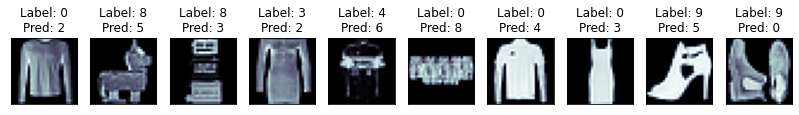

In [ ]:
# retrain the best model
best_hidden = 512
best_lr = 0.005
best_clf = NeuralNetwork(train_images.shape[1], best_hidden, train_labels.shape[1])
history = best_clf.train(X=train_images, y=train_labels, batch_size=100, lr=best_lr, max_epochs=10, verbose=False)

loss = best_clf.evaluate(test_images, test_labels)
sort_loss = np.argsort(loss) # get the indices that would sort loss (ascending)
largest_loss =  test_images[ sort_loss[-10:] ] # get the ten test images w/ the largest loss
largest_loss_labels = test_labels[ sort_loss[-10:] ]

y_pred = best_clf.predict(test_images)
pred_labels = y_pred[ sort_loss[-10:] ]
# print(f'predicted: { np.argmax(pred_labels, axis=1) }')
# print(f'accuracy: { accuracy(test_labels, y_pred) }')

# Plot examples from dataset.
plt.figure(1, figsize=(14,6))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(largest_loss[i,:].reshape(28,28), cmap='bone')
    plt.title(f'Label: {largest_loss_labels[i].argmax()}\n'
             +f'Pred: {pred_labels[i].argmax()}')
    plt.xticks([])
    plt.yticks([])